<a href="https://colab.research.google.com/github/siddharth2011/BotDetectionUsingTransformers/blob/main/T5_Bot_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    IN_COLAB = True
except:
    
    IN_COLAB = False

Mounted at /content/drive


In [ ]:
if IN_COLAB:
  !pip install transformers
  !pip install datasets
  !pip install evaluate
  !pip install sentencepiece

In [3]:
import os
import torch

if IN_COLAB:
    root_path = '/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/T-5-Approach/InstructABSA'
else:
    root_path = os.getcwd()
    
use_mps = True if torch.has_mps else False
os.chdir(root_path)

In [61]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import DatasetDict, Dataset
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from InstructABSA.utils import T5Classifier

## Training

In [ ]:
task_name = 'botnet'
experiment_name = 'botnet'
model_checkpoint = 'allenai/tk-instruct-base-def-pos'
print('Experiment Name: ', experiment_name)
model_out_path = '/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/T-5-Approach'
model_out_path = os.path.join(model_out_path, task_name, f"{model_checkpoint.replace('/', '')}-{experiment_name}")
print('Model output path: ', model_out_path)

In [ ]:
# Load the data
path = "/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/concatenated_T5_data.csv"
df= pd.read_csv(path)

In [ ]:
instruction = """The output will be either bot or human based on the input tweet.
Positive example 1-
input: id = 3982731976.0, id_str = 3982731976, screen_name = mcgucket_bot, location = nan, description = A bot that tweets every line said by Fiddleford McGucket on Gravity Falls every 30 minutes., url = nan, followers_count = 1129, friends_count = 7, listedcount = 2, created_at = Sat Oct 17 22:35:31 +0000 2015, favourites_count = 0, verified = False, statuses_count = 23557, lang = en, status = {'retweeted': False, 'is_quote_status': False, 'favorite_count': 0, 'retweet_count': 0, 'place': None, 'in_reply_to_status_id': None, 'entities': {'urls': [], 'user_mentions': [], 'hashtags': [], 'symbols': []}, 'geo': None, 'id_str': '841319282986237952', 'in_reply_to_screen_name': None, 'text': "It's happening! The End Times! When that machine activates... I gotta get outta town!", 'in_reply_to_user_id_str': None, 'source': '<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>', 'truncated': False, 'in_reply_to_user_id': None, 'created_at': 'Mon Mar 13 16:05:22 +0000 2017', 'contributors': None, 'in_reply_to_status_id_str': None, 'lang': 'en', 'id': 841319282986237952, 'favorited': False, 'coordinates': None}, default_profile = False, default_profile_image = False, has_extended_profile = False, name = McGucket bot
output: 1
Positive example 2-
input: id = 7.62e+17, id_str = 7.62E+17, screen_name = IzzieStark99, location = Minnesota, USA, description = nan, url = None, followers_count = 13, friends_count = 25, listedcount = 0, created_at = Fri Oct 01 01:04:18 +0000 2010, favourites_count = 7, verified = False, statuses_count = 0, lang = en, status = None, default_profile = False, default_profile_image = False, has_extended_profile = nan, name = izzie starkweather
output: 0
Now complete the following example-
input: """

In [ ]:
lst=[]
for row in df['raw_data']:
    lst.append(instruction + row + "\noutput:")

df['text'] = lst
df.rename(columns = {'bot':'labels'}, inplace = True)

In [ ]:
np.random.seed(112)
id_tr_df, id_te_df, id_val_df = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

In [ ]:
id_tr_df['labels'] = id_tr_df['labels'].map({0:'human', 1:'bot'})
id_te_df['labels'] = id_te_df['labels'].map({0:'human', 1:'bot'})
id_val_df['labels'] = id_val_df['labels'].map({0:'human', 1:'bot'})

In [ ]:
tokenized_ds = DatasetDict({"train": Dataset.from_pandas(id_tr_df), "test" : Dataset.from_pandas(id_te_df), "validation" : Dataset.from_pandas(id_val_df)})

In [ ]:
print(tokenized_ds['train']['text'][1656])
print(tokenized_ds['train']['labels'][1656])

The output will be either bot or human based on the input tweet.
Positive example 1-
input: id = 3982731976.0, id_str = 3982731976, screen_name = mcgucket_bot, location = nan, description = A bot that tweets every line said by Fiddleford McGucket on Gravity Falls every 30 minutes., url = nan, followers_count = 1129, friends_count = 7, listedcount = 2, created_at = Sat Oct 17 22:35:31 +0000 2015, favourites_count = 0, verified = False, statuses_count = 23557, lang = en, status = {'retweeted': False, 'is_quote_status': False, 'favorite_count': 0, 'retweet_count': 0, 'place': None, 'in_reply_to_status_id': None, 'entities': {'urls': [], 'user_mentions': [], 'hashtags': [], 'symbols': []}, 'geo': None, 'id_str': '841319282986237952', 'in_reply_to_screen_name': None, 'text': "It's happening! The End Times! When that machine activates... I gotta get outta town!", 'in_reply_to_user_id_str': None, 'source': '<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>', 'truncated': False, '

In [ ]:
# Create T5 utils object
t5_exp = T5Classifier(model_checkpoint)

In [ ]:
tokenized_ds = tokenized_ds.map(t5_exp.tokenize_function_inputs)

In [ ]:
# Training arguments
training_args = {
    'output_dir':model_out_path,
    'evaluation_strategy':"epoch",
    'learning_rate':5e-5,
    'per_device_train_batch_size':8,
    'per_device_eval_batch_size':16,
    'num_train_epochs':5,
    'weight_decay':0.01,
    'warmup_ratio':0.1,
    'save_strategy':'no',
    'load_best_model_at_end':False,
    'push_to_hub':False,
    'eval_accumulation_steps':1,
    'predict_with_generate':True,
    'use_mps_device':use_mps
}

In [ ]:
# Train model
model_trainer = t5_exp.train(tokenized_ds, **training_args)

Trainer device: cuda:0

Model training started ....


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,0.372307
2,No log,0.418197
3,0.617600,0.349708
4,0.617600,0.347268
5,0.389300,0.348508


## Evaluation

In [14]:
# Load the data
path = "/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/concatenated_T5_data.csv"
df= pd.read_csv(path)

instruction = """The output will be either bot or human based on the input tweet.
Positive example 1-
input: id = 3982731976.0, id_str = 3982731976, screen_name = mcgucket_bot, location = nan, description = A bot that tweets every line said by Fiddleford McGucket on Gravity Falls every 30 minutes., url = nan, followers_count = 1129, friends_count = 7, listedcount = 2, created_at = Sat Oct 17 22:35:31 +0000 2015, favourites_count = 0, verified = False, statuses_count = 23557, lang = en, status = {'retweeted': False, 'is_quote_status': False, 'favorite_count': 0, 'retweet_count': 0, 'place': None, 'in_reply_to_status_id': None, 'entities': {'urls': [], 'user_mentions': [], 'hashtags': [], 'symbols': []}, 'geo': None, 'id_str': '841319282986237952', 'in_reply_to_screen_name': None, 'text': "It's happening! The End Times! When that machine activates... I gotta get outta town!", 'in_reply_to_user_id_str': None, 'source': '<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>', 'truncated': False, 'in_reply_to_user_id': None, 'created_at': 'Mon Mar 13 16:05:22 +0000 2017', 'contributors': None, 'in_reply_to_status_id_str': None, 'lang': 'en', 'id': 841319282986237952, 'favorited': False, 'coordinates': None}, default_profile = False, default_profile_image = False, has_extended_profile = False, name = McGucket bot
output: 1
Positive example 2-
input: id = 7.62e+17, id_str = 7.62E+17, screen_name = IzzieStark99, location = Minnesota, USA, description = nan, url = None, followers_count = 13, friends_count = 25, listedcount = 0, created_at = Fri Oct 01 01:04:18 +0000 2010, favourites_count = 7, verified = False, statuses_count = 0, lang = en, status = None, default_profile = False, default_profile_image = False, has_extended_profile = nan, name = izzie starkweather
output: 0
Now complete the following example-
input: """

lst=[]
for row in df['raw_data']:
    lst.append(instruction + row + "\noutput:")

df['text'] = lst
df.rename(columns = {'bot':'labels'}, inplace = True)

np.random.seed(112)
id_tr_df, id_te_df, id_val_df = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

id_tr_df['labels'] = id_tr_df['labels'].map({0:'human', 1:'bot'})
id_te_df['labels'] = id_te_df['labels'].map({0:'human', 1:'bot'})
id_val_df['labels'] = id_val_df['labels'].map({0:'human', 1:'bot'})

id_ds = DatasetDict({"train": Dataset.from_pandas(id_tr_df), "test" : Dataset.from_pandas(id_te_df), "validation" : Dataset.from_pandas(id_val_df)})

# Tokenize the dataset
tokenized_ds = id_ds.map(t5_exp.tokenize_function_inputs)

In [17]:
# Model inference - Loading from Checkpoint
model_out_path = '/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/T-5-Approach/botnet/allenaitk-instruct-base-def-pos-botnet'
t5_exp = T5Classifier(model_out_path)

# Get prediction labels - Training set
id_tr_pred_labels = t5_exp.get_labels(tokenized_dataset = tokenized_ds, sample_set = 'train')
id_tr_labels = id_tr_df['labels'].tolist()

# Get prediction labels - Testing set
id_te_pred_labels = t5_exp.get_labels(tokenized_dataset = tokenized_ds, sample_set = 'test')
id_te_labels = id_te_df['labels'].tolist()

Prediction from checkpoint
Model loaded to:  cuda


100%|██████████| 447/447 [01:36<00:00,  4.66it/s]


Prediction from checkpoint
Model loaded to:  cuda


100%|██████████| 56/56 [00:11<00:00,  4.77it/s]


In [18]:
# Compute Metrics
id_te_labels_g = [1 if item == 'Bot' else 0 for item in id_te_labels]
id_te_pred_labels_g = [1 if item == 'Bot' else 0 for item in id_te_pred_labels]

p, r, f1, acc = t5_exp.get_metrics(id_tr_labels, id_tr_pred_labels)
print('Train Precision: ', p)
print('Train Recall: ', r)
print('Train F1: ', f1)
print('Train Accuracy: ', acc)
# print('Train ROC AUC score: ', roc_auc_score(id_tr_labels, id_tr_pred_labels))

p, r, f1, acc = t5_exp.get_metrics(id_te_labels, id_te_pred_labels)
print('Test Precision: ', p)
print('Test Recall: ', r)
print('Test F1: ', f1)
print('Test Accuracy: ', acc)
# print('Test ROC AUC score: ', roc_auc_score(id_te_labels, id_te_pred_labels))

Train Precision:  0.2607843137254902
Train Recall:  0.5
Train F1:  0.34278350515463923
Train Accuracy:  0.5215686274509804
Test Precision:  0.257847533632287
Test Recall:  0.5
Test F1:  0.3402366863905326
Test Accuracy:  0.515695067264574


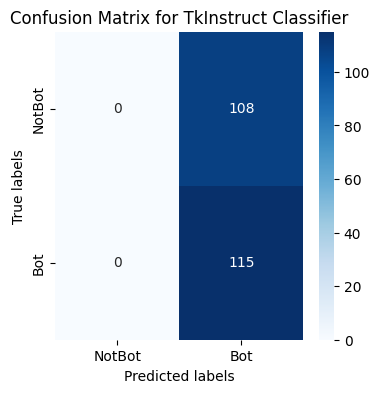

In [21]:
cm = confusion_matrix(id_te_labels, id_te_pred_labels)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for TkInstruct Classifier')
ax.xaxis.set_ticklabels(['NotBot', 'Bot'])
ax.yaxis.set_ticklabels(['NotBot', 'Bot'])
plt.show()

In [60]:
# fpr, tpr, _ = roc_curve(id_te_labels_g, id_te_pred_labels_g)
# roc_auc = auc(fpr, tpr)

# fig, ax = plt.subplots(figsize=(4, 4))
# ax.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
# ax.plot([0, 1], [0, 1], color='navy',  linestyle='--')
# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('ROC Curve for TkInstruct Classifier')
# ax.legend(loc="lower right")
# plt.show()

## Demo

In [26]:
# Load the data
path = "/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/concatenated_T5_data.csv"
df= pd.read_csv(path)

instruction = """The output will be either bot or human based on the input tweet.
Positive example 1-
input: id = 3982731976.0, id_str = 3982731976, screen_name = mcgucket_bot, location = nan, description = A bot that tweets every line said by Fiddleford McGucket on Gravity Falls every 30 minutes., url = nan, followers_count = 1129, friends_count = 7, listedcount = 2, created_at = Sat Oct 17 22:35:31 +0000 2015, favourites_count = 0, verified = False, statuses_count = 23557, lang = en, status = {'retweeted': False, 'is_quote_status': False, 'favorite_count': 0, 'retweet_count': 0, 'place': None, 'in_reply_to_status_id': None, 'entities': {'urls': [], 'user_mentions': [], 'hashtags': [], 'symbols': []}, 'geo': None, 'id_str': '841319282986237952', 'in_reply_to_screen_name': None, 'text': "It's happening! The End Times! When that machine activates... I gotta get outta town!", 'in_reply_to_user_id_str': None, 'source': '<a href="http://twittbot.net/" rel="nofollow">twittbot.net</a>', 'truncated': False, 'in_reply_to_user_id': None, 'created_at': 'Mon Mar 13 16:05:22 +0000 2017', 'contributors': None, 'in_reply_to_status_id_str': None, 'lang': 'en', 'id': 841319282986237952, 'favorited': False, 'coordinates': None}, default_profile = False, default_profile_image = False, has_extended_profile = False, name = McGucket bot
output: 1
Positive example 2-
input: id = 7.62e+17, id_str = 7.62E+17, screen_name = IzzieStark99, location = Minnesota, USA, description = nan, url = None, followers_count = 13, friends_count = 25, listedcount = 0, created_at = Fri Oct 01 01:04:18 +0000 2010, favourites_count = 7, verified = False, statuses_count = 0, lang = en, status = None, default_profile = False, default_profile_image = False, has_extended_profile = nan, name = izzie starkweather
output: 0
Now complete the following example-
input: """

lst=[]
for row in df['raw_data']:
    lst.append(instruction + row + "\noutput:")

df['text'] = lst
df.rename(columns = {'bot':'labels'}, inplace = True)

np.random.seed(112)
id_tr_df, id_te_df, id_val_df = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

id_tr_df['labels'] = id_tr_df['labels'].map({0:'human', 1:'bot'})
id_te_df['labels'] = id_te_df['labels'].map({0:'human', 1:'bot'})
id_val_df['labels'] = id_val_df['labels'].map({0:'human', 1:'bot'})

id_ds = DatasetDict({"train": Dataset.from_pandas(id_tr_df), "test" : Dataset.from_pandas(id_te_df), "validation" : Dataset.from_pandas(id_val_df)})

# Tokenize the dataset
tokenized_ds = id_ds.map(t5_exp.tokenize_function_inputs)

Map:   0%|          | 0/1785 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [28]:
# Model inference - Loading from Checkpoint
model_out_path = '/content/drive/Othercomputers/My Laptop/D:/ASU/SWM/T-5-Approach/botnet/allenaitk-instruct-base-def-pos-botnet'
t5_exp = T5Classifier(model_out_path)

In [53]:
test_idx = 25
sample = tokenized_ds['test'][test_idx]
gt_label = t5_exp.tokenizer.decode(tokenized_ds['test']['labels'][test_idx], skip_special_tokens=True)
output_ids = t5_exp.model.generate(torch.tensor([sample['input_ids']]))
prediction = t5_exp.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print()
print(f'Model prediction: {gt_label} ---> Ground truth: {prediction}')


Model prediction: bot ---> Ground truth: human


In [63]:
test_idx = 6
sample = tokenized_ds['test'][test_idx]
gt_label = t5_exp.tokenizer.decode(tokenized_ds['test']['labels'][test_idx], skip_special_tokens=True)
output_ids = t5_exp.model.generate(torch.tensor([sample['input_ids']]))
prediction = t5_exp.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print()
print(f'Model prediction: {gt_label} ---> Ground truth: {prediction}')


Model prediction: human ---> Ground truth: human


In [64]:
test_idx = 1
sample = tokenized_ds['test'][test_idx]
gt_label = t5_exp.tokenizer.decode(tokenized_ds['test']['labels'][test_idx], skip_special_tokens=True)
output_ids = t5_exp.model.generate(torch.tensor([sample['input_ids']]))
prediction = t5_exp.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print()
print(f'Model prediction: {gt_label} ---> Ground truth: {prediction}')


Model prediction: bot ---> Ground truth: human


In [62]:
test_idx = 35
sample = tokenized_ds['test'][test_idx]
gt_label = t5_exp.tokenizer.decode(tokenized_ds['test']['labels'][test_idx], skip_special_tokens=True)
output_ids = t5_exp.model.generate(torch.tensor([sample['input_ids']]))
prediction = t5_exp.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
print()
print(f'Model prediction: {gt_label} ---> Ground truth: {prediction}')


Model prediction: bot ---> Ground truth: human
